In [7]:
import sys
sys.path.append('../src')

import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report
import pandas as pd
from pathlib import Path

from model import create_model
from data import get_dataloaders, get_class_names, denormalize
from utils import load_config, load_checkpoint

# Set style
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (14, 8)

# Device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

Using device: cuda


In [8]:
# Load configuration
config = load_config('../config.yaml')

# Load dataloaders
train_loader, val_loader, test_loader = get_dataloaders(config)
class_names = get_class_names()

# Create model
model = create_model(config).to(device)

# Load best checkpoint
checkpoint_path = '../results/checkpoints/checkpoint_epoch_1_best.pth'
if Path(checkpoint_path).exists():
    load_checkpoint(checkpoint_path, model)
    print("Loaded best model checkpoint")
else:
    print("Warning: No checkpoint found. Using untrained model.")

model.eval()
print(f"Model parameters: {sum(p.numel() for p in model.parameters()): }")

Loading CIFAR-10 dataset...


/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Training samples: 45000
Validation samples: 5000
Test samples: 10000
Model parameters:  21268938


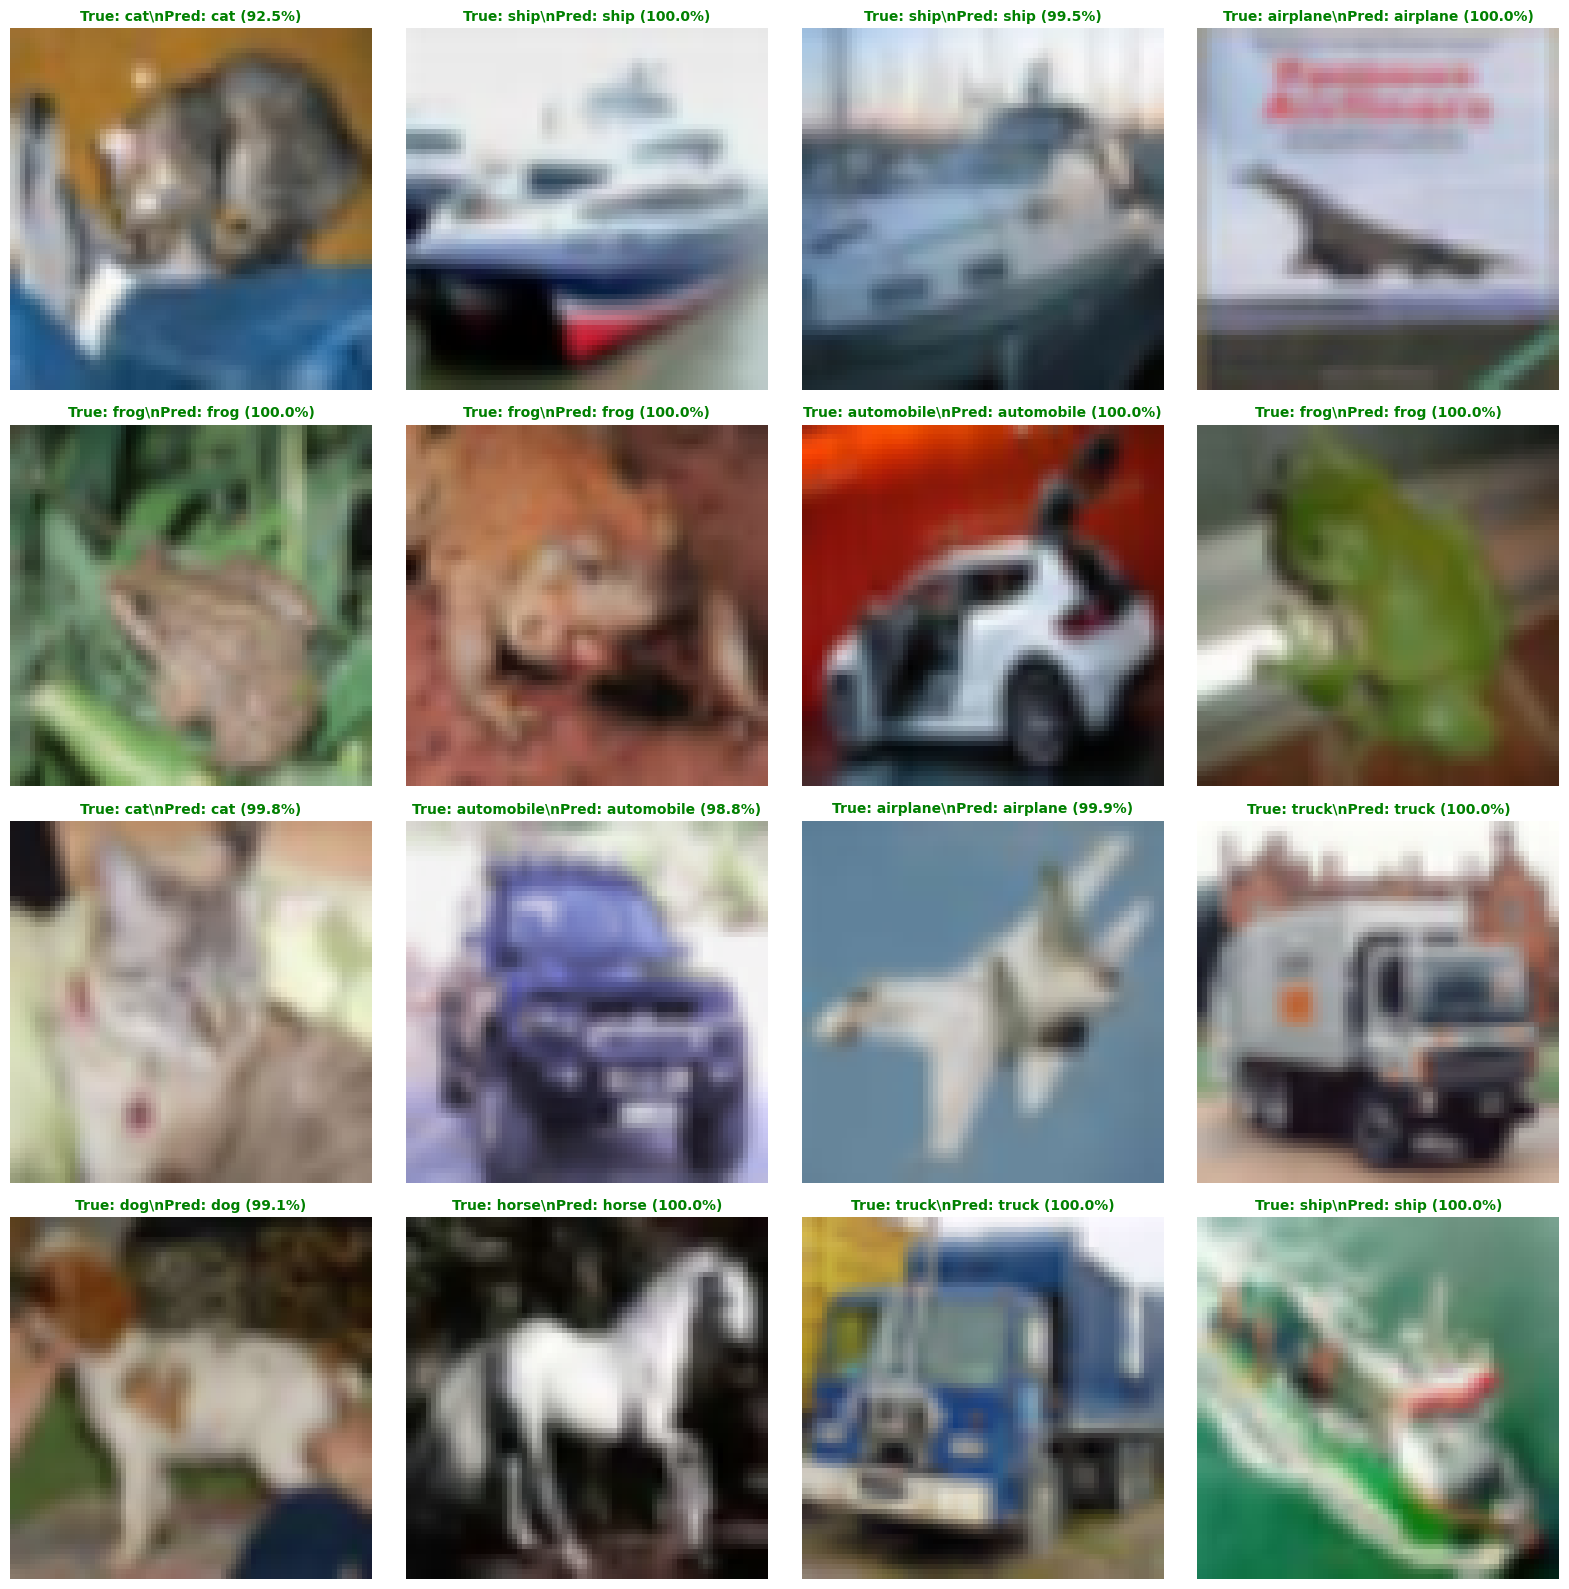


Batch Accuracy: 16/16 = 100.0%
Average confidence: 0.993


In [30]:
## 2. Model Predictions Visualization - SIMPLE VERSION

# Get a batch of test images
images, labels = next(iter(test_loader))
images_gpu = images.to(device)

# Get predictions
with torch.no_grad():
    outputs = model(images_gpu)
    probabilities = torch.softmax(outputs, dim=1)
    confidences, predictions = torch.max(probabilities, 1)

# Move to CPU
predictions = predictions.cpu()
confidences = confidences.cpu()

# Simple filtering: just take first 16 and calculate accuracy on those
num_images = min(16, len(images))

# Visualize predictions
fig, axes = plt.subplots(4, 4, figsize=(16, 16))
axes = axes.flatten()

correct_count = 0
for idx in range(num_images):
    ax = axes[idx]

    # Denormalize image
    img = denormalize(
        images[idx],
        config['augmentation']['normalize_mean'],
        config['augmentation']['normalize_std']
    )
    img = torch.clamp(img, 0, 1)

    # Plot image
    ax.imshow(img.permute(1, 2, 0))

    # Add title with prediction
    true_label = class_names[labels[idx]]
    pred_label = class_names[predictions[idx]]
    confidence = confidences[idx].item() * 100

    is_correct = labels[idx] == predictions[idx]
    if is_correct:
        correct_count += 1
        color = 'green'
    else:
        color = 'red'

    ax.set_title(
        f'True: {true_label}\\nPred: {pred_label} ({confidence:.1f}%)',
        color=color,
        fontsize=10,
        fontweight='bold'
    )
    ax.axis('off')

# Hide unused subplots
for idx in range(num_images, len(axes)):
    axes[idx].axis('off')

plt.tight_layout()
plt.savefig('../results/plots/model_predictions.png', dpi=150, bbox_inches='tight')
plt.show()

print(f"\nBatch Accuracy: {correct_count}/{num_images} = {100*correct_count/num_images:.1f}%")
print(f"Average confidence: {confidences[:num_images].mean().item():.3f}")

Evaluating on test set...


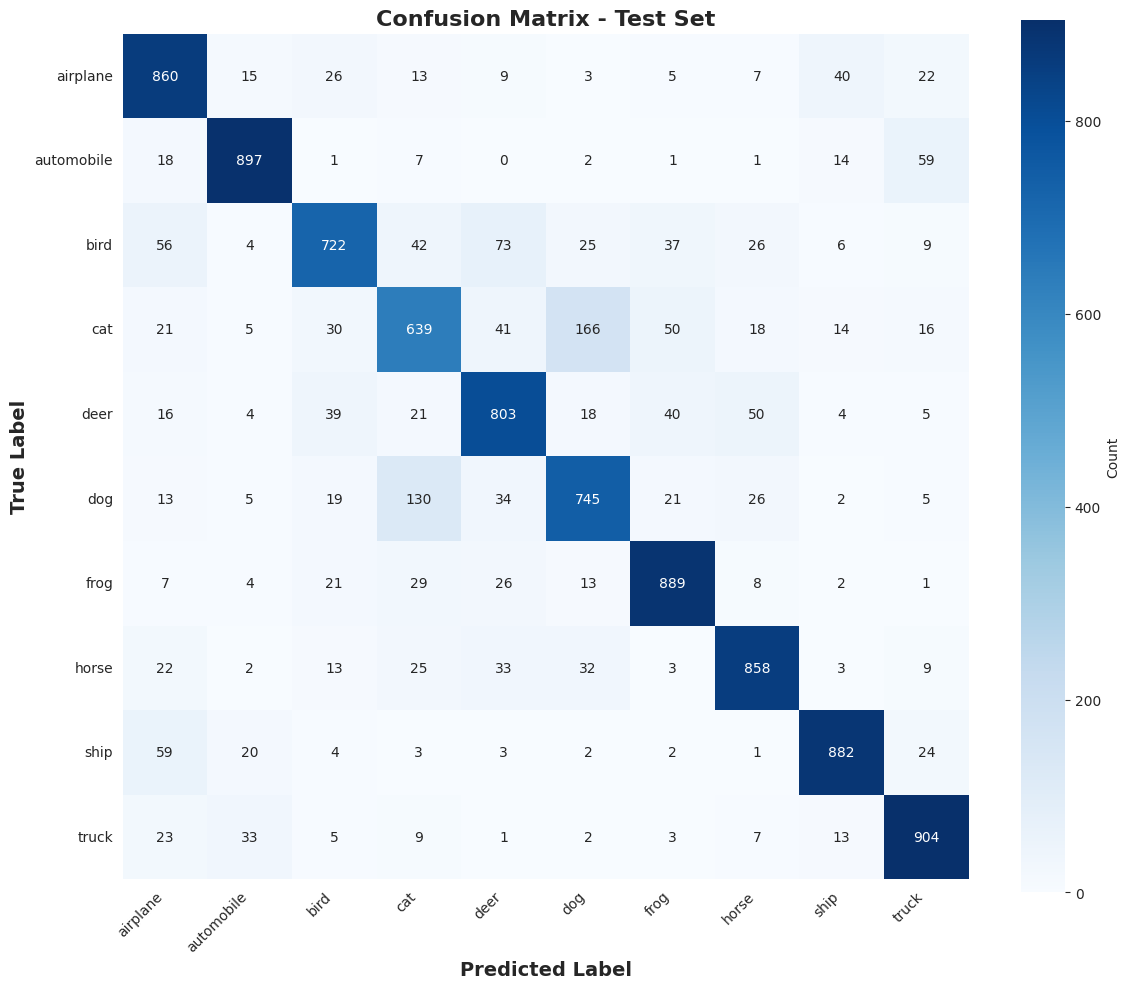


Test Set Accuracy: 81.99%


In [31]:
# Collect predictions on entire test set
all_predictions = []
all_labels = []

print("Evaluating on test set...")
with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(device)
        outputs = model(images)
        _, predictions = torch.max(outputs, 1)

        all_predictions.extend(predictions.cpu().numpy())
        all_labels.extend(labels.numpy())

# Calculate confusion matrix
cm = confusion_matrix(all_labels, all_predictions)

# Plot
plt.figure(figsize=(12, 10))
sns.heatmap(
    cm,
    annot=True,
    fmt='d',
    cmap='Blues',
    xticklabels=class_names,
    yticklabels=class_names,
    cbar_kws={'label': 'Count'},
    square=True
)
plt.xlabel('Predicted Label', fontsize=14, fontweight='bold')
plt.ylabel('True Label', fontsize=14, fontweight='bold')
plt.title('Confusion Matrix - Test Set', fontsize=16, fontweight='bold')
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.savefig('../results/plots/detailed_confusion_matrix.png', dpi=150, bbox_inches='tight')
plt.show()

# Calculate overall accuracy
accuracy = 100 * np.sum(np.array(all_predictions) == np.array(all_labels)) / len(all_labels)
print(f"\nTest Set Accuracy: {accuracy:.2f}%")

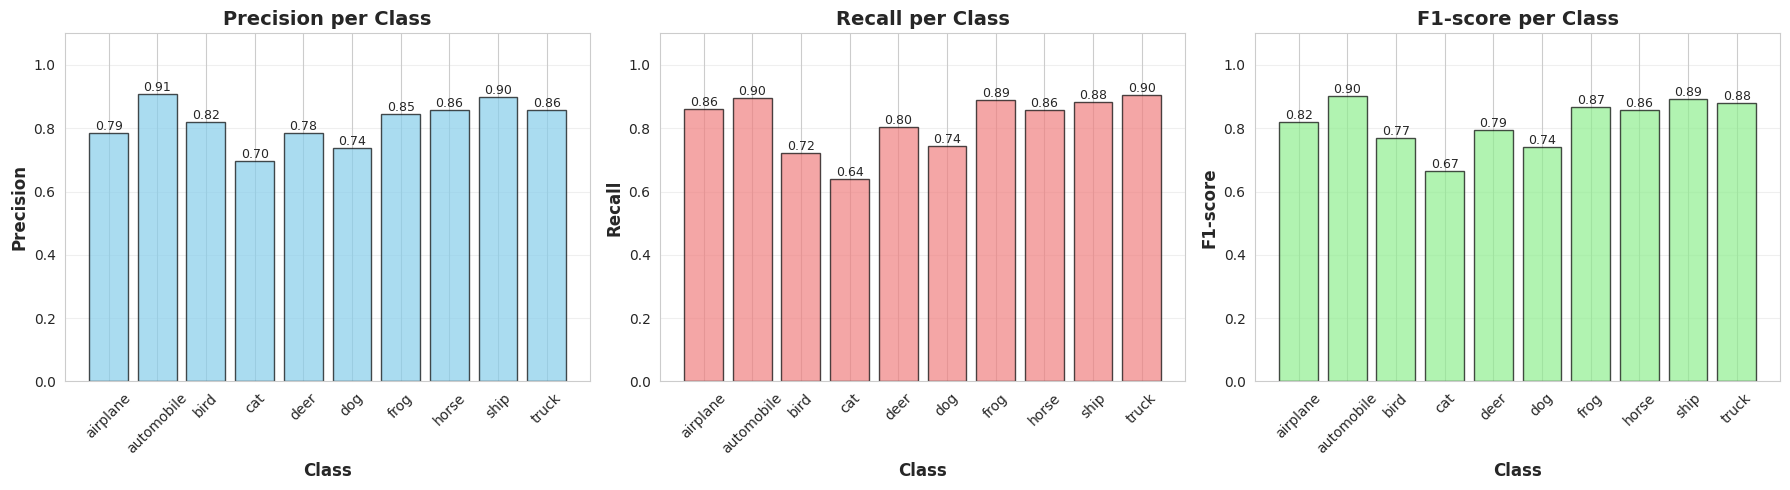


Detailed Classification Report:
            precision  recall  f1-score  support
airplane     0.785388   0.860  0.821002   1000.0
automobile   0.906977   0.897  0.901961   1000.0
bird         0.820455   0.722  0.768085   1000.0
cat          0.696078   0.639  0.666319   1000.0
deer         0.784946   0.803  0.793870   1000.0
dog          0.739087   0.745  0.742032   1000.0
frog         0.845861   0.889  0.866894   1000.0
horse        0.856287   0.858  0.857143   1000.0
ship         0.900000   0.882  0.890909   1000.0
truck        0.857685   0.904  0.880234   1000.0


In [32]:
# Classification report
report = classification_report(
    all_labels,
    all_predictions,
    target_names=class_names,
    output_dict=True
)

# Convert to DataFrame
df_report = pd.DataFrame(report).transpose()
df_report = df_report.iloc[:-3]  # Remove avg rows for visualization

# Plot per-class metrics
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

metrics = ['precision', 'recall', 'f1-score']
colors = ['skyblue', 'lightcoral', 'lightgreen']

for idx, (metric, color) in enumerate(zip(metrics, colors)):
    ax = axes[idx]
    values = df_report[metric].values
    bars = ax.bar(class_names, values, color=color, edgecolor='black', alpha=0.7)

    # Add value labels on bars
    for bar in bars:
        height = bar.get_height()
        ax.text(
            bar.get_x() + bar.get_width()/2.,
            height,
            f'{height:.2f}',
            ha='center',
            va='bottom',
            fontsize=9
        )

    ax.set_xlabel('Class', fontsize=12, fontweight='bold')
    ax.set_ylabel(metric.capitalize(), fontsize=12, fontweight='bold')
    ax.set_title(f'{metric.capitalize()} per Class', fontsize=14, fontweight='bold')
    ax.set_ylim([0, 1.1])
    ax.tick_params(axis='x', rotation=45)
    ax.grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.savefig('../results/plots/per_class_metrics.png', dpi=150, bbox_inches='tight')
plt.show()

# Print detailed report
print("\nDetailed Classification Report:")
print(df_report.to_string())

/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
/tmp/ipython-input-2306986761.py:31: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  bp = axes[1].boxplot(data_to_plot, labels=['Correct', 'Incorrect'], patch_artist=True)


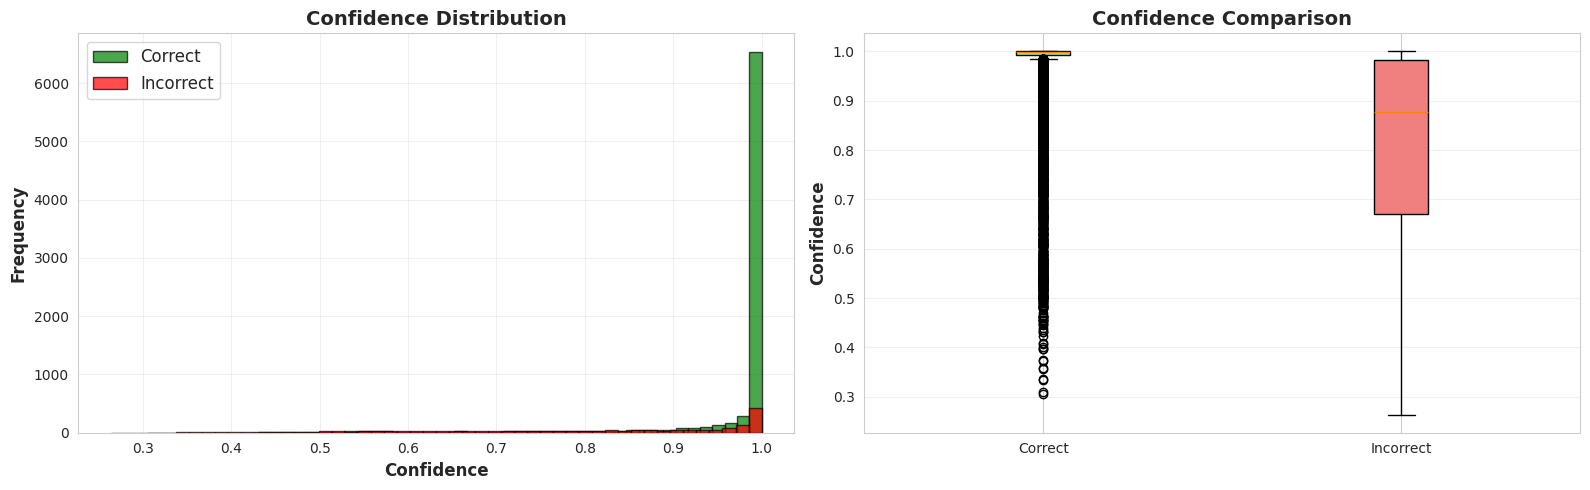


Correct predictions - Mean confidence: 0.966
Incorrect predictions - Mean confidence: 0.813


In [33]:
# Collect prediction confidences
correct_confidences = []
incorrect_confidences = []

with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(device)
        outputs = model(images)
        probabilities = torch.softmax(outputs, dim=1)
        confidences, predictions = torch.max(probabilities, 1)

        # Separate correct and incorrect predictions
        correct_mask = predictions.cpu() == labels
        correct_confidences.extend(confidences[correct_mask].cpu().numpy())
        incorrect_confidences.extend(confidences[~correct_mask].cpu().numpy())

# Plot distributions
fig, axes = plt.subplots(1, 2, figsize=(16, 5))

# Histogram
axes[0].hist(correct_confidences, bins=50, alpha=0.7, label='Correct', color='green', edgecolor='black')
axes[0].hist(incorrect_confidences, bins=50, alpha=0.7, label='Incorrect', color='red', edgecolor='black')
axes[0].set_xlabel('Confidence', fontsize=12, fontweight='bold')
axes[0].set_ylabel('Frequency', fontsize=12, fontweight='bold')
axes[0].set_title('Confidence Distribution', fontsize=14, fontweight='bold')
axes[0].legend(fontsize=12)
axes[0].grid(alpha=0.3)

# Box plot
data_to_plot = [correct_confidences, incorrect_confidences]
bp = axes[1].boxplot(data_to_plot, labels=['Correct', 'Incorrect'], patch_artist=True)
bp['boxes'][0].set_facecolor('lightgreen')
bp['boxes'][1].set_facecolor('lightcoral')
axes[1].set_ylabel('Confidence', fontsize=12, fontweight='bold')
axes[1].set_title('Confidence Comparison', fontsize=14, fontweight='bold')
axes[1].grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.savefig('../results/plots/confidence_distribution.png', dpi=150, bbox_inches='tight')
plt.show()

print(f"\nCorrect predictions - Mean confidence: {np.mean(correct_confidences):.3f}")
print(f"Incorrect predictions - Mean confidence: {np.mean(incorrect_confidences):.3f}")

Number of attention layers: 8
First layer shape: torch.Size([1, 144, 144])
First layer type: <class 'torch.Tensor'>
No batch dimension needed: torch.Size([1, 144, 144])


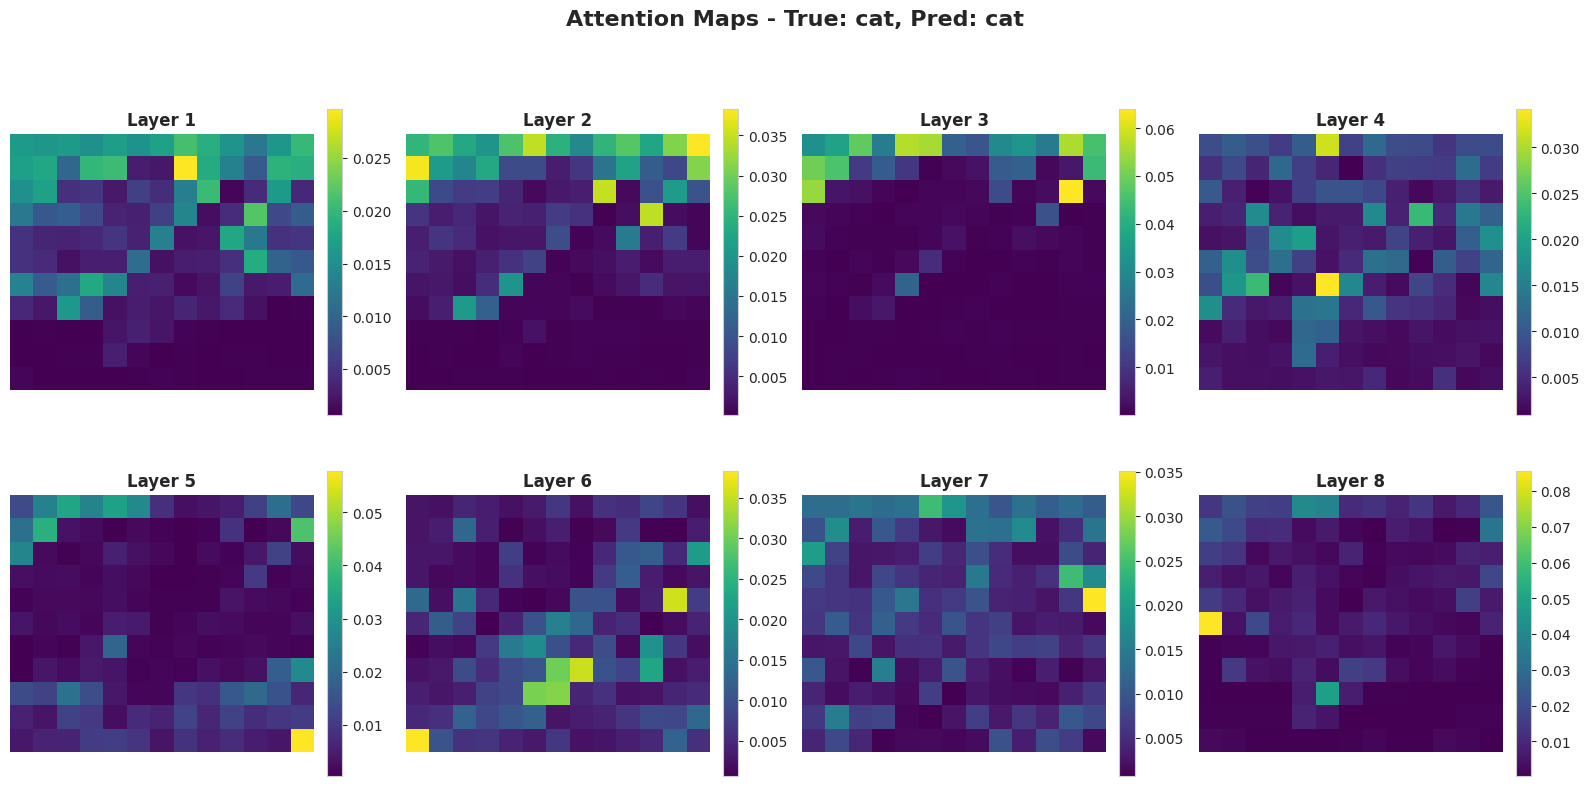

In [41]:
# Get a single image
images, labels = next(iter(test_loader))
image = images[0:1].to(device)
label = labels[0]

# Get attention maps
with torch.no_grad():
    logits, attention_weights = model(image, return_attention=True)
    prediction = torch.argmax(logits, dim=1)

print(f"Number of attention layers: {len(attention_weights)}")

# Let's examine the first layer in detail
first_layer_attn = attention_weights[0]
print(f"First layer shape: {first_layer_attn.shape}")
print(f"First layer type: {type(first_layer_attn)}")

# Check if it's a tuple or list
if isinstance(first_layer_attn, (tuple, list)):
    print("Attention weights are in a tuple/list")
    for i, item in enumerate(first_layer_attn):
        print(f"  Item {i}: shape {item.shape if hasattr(item, 'shape') else 'no shape'}")
    # Use the first item if it's a tuple
    first_layer_attn = first_layer_attn[0]

# Remove batch dimension
if first_layer_attn.dim() == 4:
    attn_no_batch = first_layer_attn[0]  # (num_heads, seq_len, seq_len)
    print(f"After batch removal: {attn_no_batch.shape}")
elif first_layer_attn.dim() == 3:
    attn_no_batch = first_layer_attn  # Already no batch dimension
    print(f"No batch dimension needed: {attn_no_batch.shape}")
else:
    print(f"Unexpected dimension: {first_layer_attn.dim()}")

# Now proceed with visualization
num_layers_to_show = min(8, len(attention_weights))
fig, axes = plt.subplots(2, 4, figsize=(16, 8))
axes = axes.flatten()

grid_h, grid_w = 11, 13  # For 143 patches

for layer_idx in range(num_layers_to_show):
    ax = axes[layer_idx]

    try:
        # Get this layer's attention
        layer_attn = attention_weights[layer_idx]

        # Handle different formats
        if isinstance(layer_attn, (tuple, list)):
            layer_attn = layer_attn[0]  # Take first element if it's a tuple

        # Remove batch dimension if present
        if layer_attn.dim() == 4:
            attn_heads = layer_attn[0]  # (num_heads, seq_len, seq_len)
        else:
            attn_heads = layer_attn  # (num_heads, seq_len, seq_len)

        # Get CLS token attention to patches
        cls_attention = attn_heads[:, 0, 1:]  # (num_heads, num_patches)

        # Average across heads and reshape
        attn_avg = cls_attention.mean(dim=0)  # (num_patches,)
        attn_map = attn_avg.cpu().reshape(grid_h, grid_w)

        # Plot
        im = ax.imshow(attn_map, cmap='viridis', interpolation='nearest')
        ax.set_title(f'Layer {layer_idx + 1}', fontsize=12, fontweight='bold')
        ax.axis('off')
        plt.colorbar(im, ax=ax, fraction=0.046, pad=0.04)

    except Exception as e:
        print(f"Error in layer {layer_idx}: {e}")
        # Try alternative approach
        try:
            # Maybe the attention is already processed differently
            layer_attn = attention_weights[layer_idx]
            print(f"Layer {layer_idx} type: {type(layer_attn)}, shape: {getattr(layer_attn, 'shape', 'no shape')}")
        except:
            pass
        ax.text(0.5, 0.5, f'Error\nLayer {layer_idx+1}',
                transform=ax.transAxes, ha='center', va='center', fontsize=10)
        ax.axis('off')

plt.suptitle(
    f'Attention Maps - True: {class_names[label]}, Pred: {class_names[prediction[0]]}',
    fontsize=16,
    fontweight='bold',
    y=1.02
)
plt.tight_layout()
plt.savefig('../results/plots/attention_maps_fixed.png', dpi=150, bbox_inches='tight')
plt.show()

Image size: 72, Patch size: 6
Expected: 12x12 = 144 patches
Number of attention layers: 8
First layer shape: torch.Size([1, 144, 144])
Error getting attention from layer 1: cannot access local variable 'attn_heads' where it is not associated with a value
Error getting attention from layer -1: cannot access local variable 'attn_heads' where it is not associated with a value
Error getting attention from layer 1: cannot access local variable 'attn_heads' where it is not associated with a value
Error getting attention from layer -1: cannot access local variable 'attn_heads' where it is not associated with a value
Error getting attention from layer 1: cannot access local variable 'attn_heads' where it is not associated with a value
Error getting attention from layer -1: cannot access local variable 'attn_heads' where it is not associated with a value
Error getting attention from layer 1: cannot access local variable 'attn_heads' where it is not associated with a value
Error getting attentio

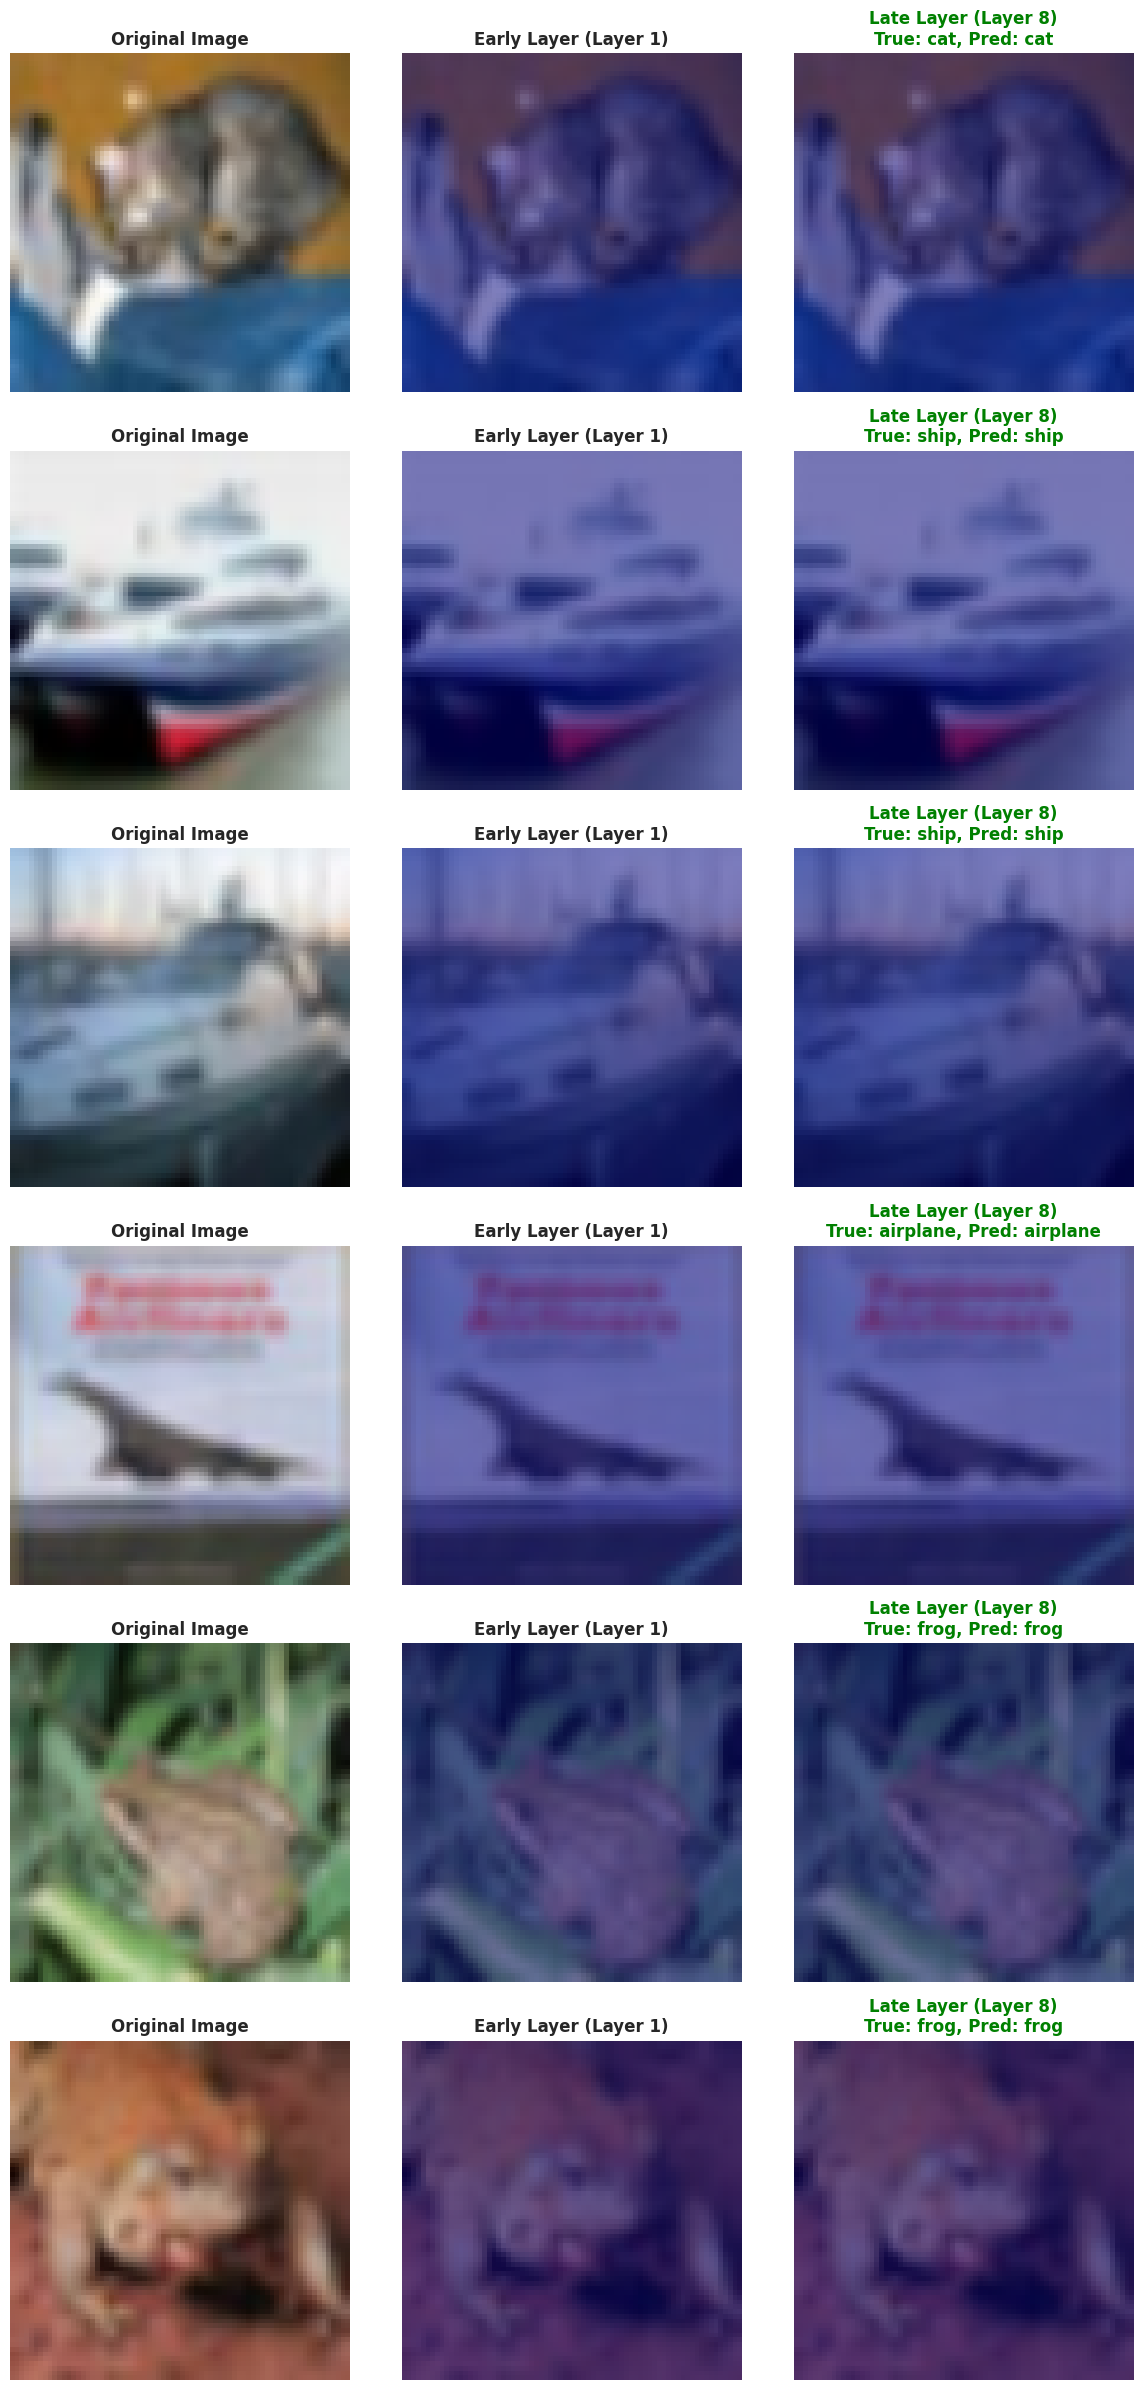

In [44]:
# Select a few images to visualize
num_samples = 6
images, labels = next(iter(test_loader))
images_gpu = images[:num_samples].to(device)

# Calculate patch grid dimensions
image_size = config['data']['image_size']
patch_size = config['model']['patch_size']
patch_per_dim = image_size // patch_size
expected_patches = patch_per_dim * patch_per_dim

print(f"Image size: {image_size}, Patch size: {patch_size}")
print(f"Expected: {patch_per_dim}x{patch_per_dim} = {expected_patches} patches")

fig, axes = plt.subplots(num_samples, 3, figsize=(12, 4*num_samples))

def get_cls_attention_map(attention_weights, layer_idx, patch_per_dim):
    """Extract CLS attention map from specified layer"""
    try:
        layer_attn = attention_weights[layer_idx]

        # Handle different formats
        if isinstance(layer_attn, (tuple, list)):
            layer_attn = layer_attn[0]

        # Remove batch dimension
        if layer_attn.dim() == 4:
            attn_heads = layer_attn[0]  # (num_heads, seq_len, seq_len)
        else:
            attn_attn_heads = layer_attn

        # Get CLS token attention to patches
        seq_len = attn_heads.shape[-1]
        num_patches = seq_len - 1

        # Take only the expected number of patches
        cls_attention = attn_heads[:, 0, 1:1+expected_patches]  # (num_heads, expected_patches)

        # Average across heads and reshape
        attn_avg = cls_attention.mean(dim=0)  # (expected_patches,)
        attn_map = attn_avg.cpu().reshape(patch_per_dim, patch_per_dim)

        return attn_map

    except Exception as e:
        print(f"Error getting attention from layer {layer_idx}: {e}")
        # Return a blank map
        return torch.zeros(patch_per_dim, patch_per_dim)

for img_idx in range(num_samples):
    image = images_gpu[img_idx:img_idx+1]
    label = labels[img_idx]

    # Get prediction and attention
    with torch.no_grad():
        logits, attention_weights = model(image, return_attention=True)
        prediction = torch.argmax(logits, dim=1)

    # Print attention info for debugging
    if img_idx == 0:  # Only print for first image
        print(f"Number of attention layers: {len(attention_weights)}")
        print(f"First layer shape: {attention_weights[0].shape}")

    # Original image
    img_display = denormalize(
        images[img_idx],
        config['augmentation']['normalize_mean'],
        config['augmentation']['normalize_std']
    )
    img_display = torch.clamp(img_display, 0, 1).permute(1, 2, 0).numpy()

    # Plot original
    axes[img_idx, 0].imshow(img_display)
    axes[img_idx, 0].set_title('Original Image', fontsize=12, fontweight='bold')
    axes[img_idx, 0].axis('off')

    # Early layer attention (layer 1 instead of 2 for stability)
    attn_early_map = get_cls_attention_map(attention_weights, 1, patch_per_dim)

    # Resize to original image size
    attn_early_resized = torch.nn.functional.interpolate(
        attn_early_map.unsqueeze(0).unsqueeze(0),
        size=(image_size, image_size),
        mode='bilinear'
    ).squeeze().numpy()

    axes[img_idx, 1].imshow(img_display)
    axes[img_idx, 1].imshow(attn_early_resized, cmap='jet', alpha=0.5)
    axes[img_idx, 1].set_title(f'Early Layer (Layer 1)', fontsize=12, fontweight='bold')
    axes[img_idx, 1].axis('off')

    # Late layer attention (last layer)
    attn_late_map = get_cls_attention_map(attention_weights, -1, patch_per_dim)

    # Resize to original image size
    attn_late_resized = torch.nn.functional.interpolate(
        attn_late_map.unsqueeze(0).unsqueeze(0),
        size=(image_size, image_size),
        mode='bilinear'
    ).squeeze().numpy()

    axes[img_idx, 2].imshow(img_display)
    axes[img_idx, 2].imshow(attn_late_resized, cmap='jet', alpha=0.5)

    color = 'green' if prediction[0] == label else 'red'
    axes[img_idx, 2].set_title(
        f'Late Layer (Layer {len(attention_weights)})\nTrue: {class_names[label]}, Pred: {class_names[prediction[0]]}',
        fontsize=12,
        fontweight='bold',
        color=color
    )
    axes[img_idx, 2].axis('off')

plt.tight_layout()
plt.savefig('../results/plots/attention_overlay.png', dpi=150, bbox_inches='tight')
plt.show()

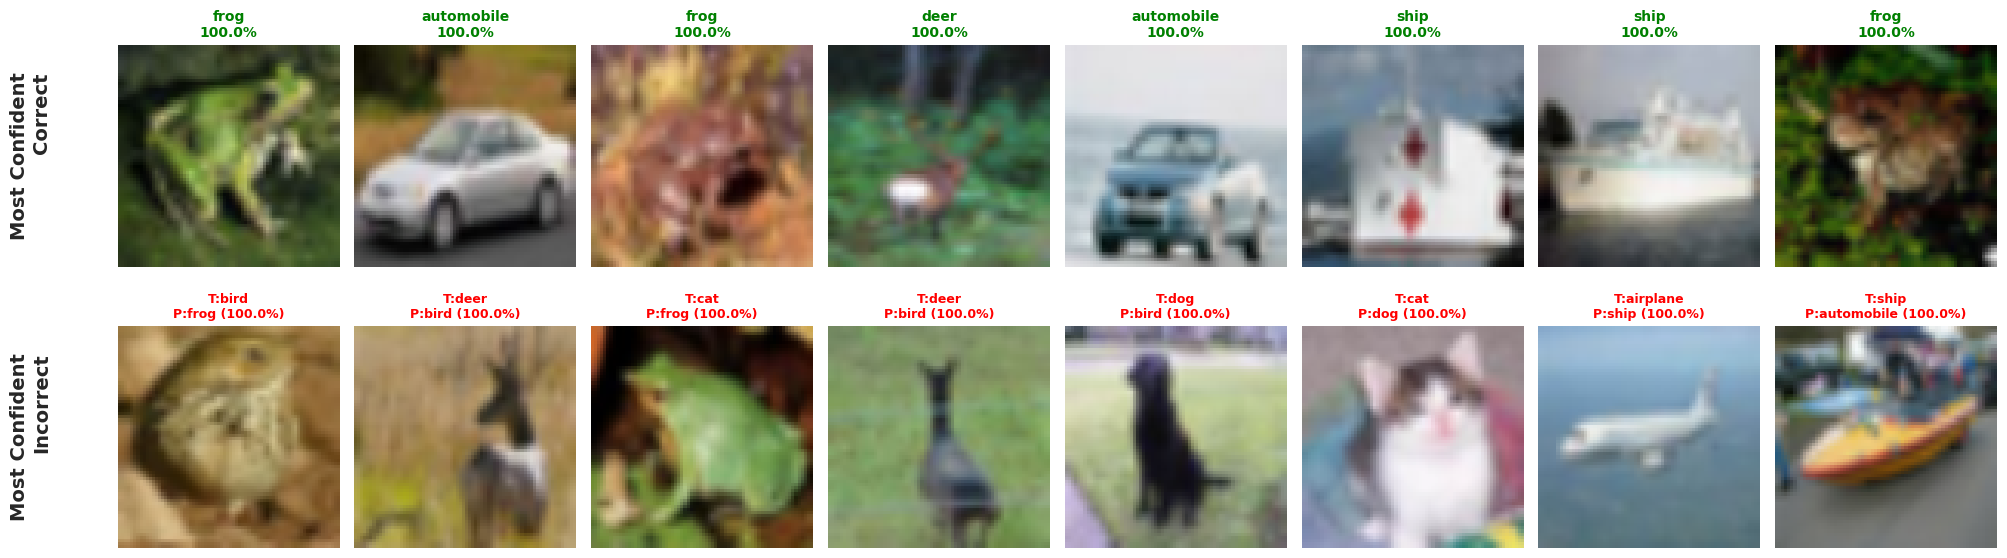

In [45]:
# Find most confident correct and incorrect predictions
all_images = []
all_labels = []
all_predictions = []
all_confidences = []

with torch.no_grad():
    for images, labels in test_loader:
        images_gpu = images.to(device)
        outputs = model(images_gpu)
        probs = torch.softmax(outputs, dim=1)
        confidences, predictions = torch.max(probs, 1)

        all_images.append(images)
        all_labels.append(labels)
        all_predictions.append(predictions.cpu())
        all_confidences.append(confidences.cpu())

all_images = torch.cat(all_images)
all_labels = torch.cat(all_labels)
all_predictions = torch.cat(all_predictions)
all_confidences = torch.cat(all_confidences)

# Find top confident correct predictions
correct_mask = all_predictions == all_labels
correct_confidences = all_confidences[correct_mask]
correct_indices = torch.where(correct_mask)[0]
top_correct_indices = correct_indices[torch.argsort(correct_confidences, descending=True)[:8]]

# Find top confident incorrect predictions
incorrect_mask = all_predictions != all_labels
incorrect_confidences = all_confidences[incorrect_mask]
incorrect_indices = torch.where(incorrect_mask)[0]
top_incorrect_indices = incorrect_indices[torch.argsort(incorrect_confidences, descending=True)[:8]]

# Plot
fig, axes = plt.subplots(2, 8, figsize=(20, 6))

# Top correct
for plot_idx, data_idx in enumerate(top_correct_indices):
    ax = axes[0, plot_idx]
    img = denormalize(
        all_images[data_idx],
        config['augmentation']['normalize_mean'],
        config['augmentation']['normalize_std']
    )
    img = torch.clamp(img, 0, 1).permute(1, 2, 0).numpy()

    ax.imshow(img)
    ax.set_title(
        f'{class_names[all_labels[data_idx]]}\n{all_confidences[data_idx]*100:.1f}%',
        fontsize=10,
        fontweight='bold',
        color='green'
    )
    ax.axis('off')

# Top incorrect
for plot_idx, data_idx in enumerate(top_incorrect_indices):
    ax = axes[1, plot_idx]
    img = denormalize(
        all_images[data_idx],
        config['augmentation']['normalize_mean'],
        config['augmentation']['normalize_std']
    )
    img = torch.clamp(img, 0, 1).permute(1, 2, 0).numpy()

    ax.imshow(img)
    ax.set_title(
        f'T:{class_names[all_labels[data_idx]]}\nP:{class_names[all_predictions[data_idx]]} ({all_confidences[data_idx]*100:.1f}%)',
        fontsize=9,
        fontweight='bold',
        color='red'
    )
    ax.axis('off')

axes[0, 0].text(-0.3, 0.5, 'Most Confident\nCorrect',
                transform=axes[0, 0].transAxes,
                fontsize=14, fontweight='bold',
                va='center', ha='right', rotation=90)

axes[1, 0].text(-0.3, 0.5, 'Most Confident\nIncorrect',
                transform=axes[1, 0].transAxes,
                fontsize=14, fontweight='bold',
                va='center', ha='right', rotation=90)

plt.tight_layout()
plt.savefig('../results/plots/confident_predictions.png', dpi=150, bbox_inches='tight')
plt.show()

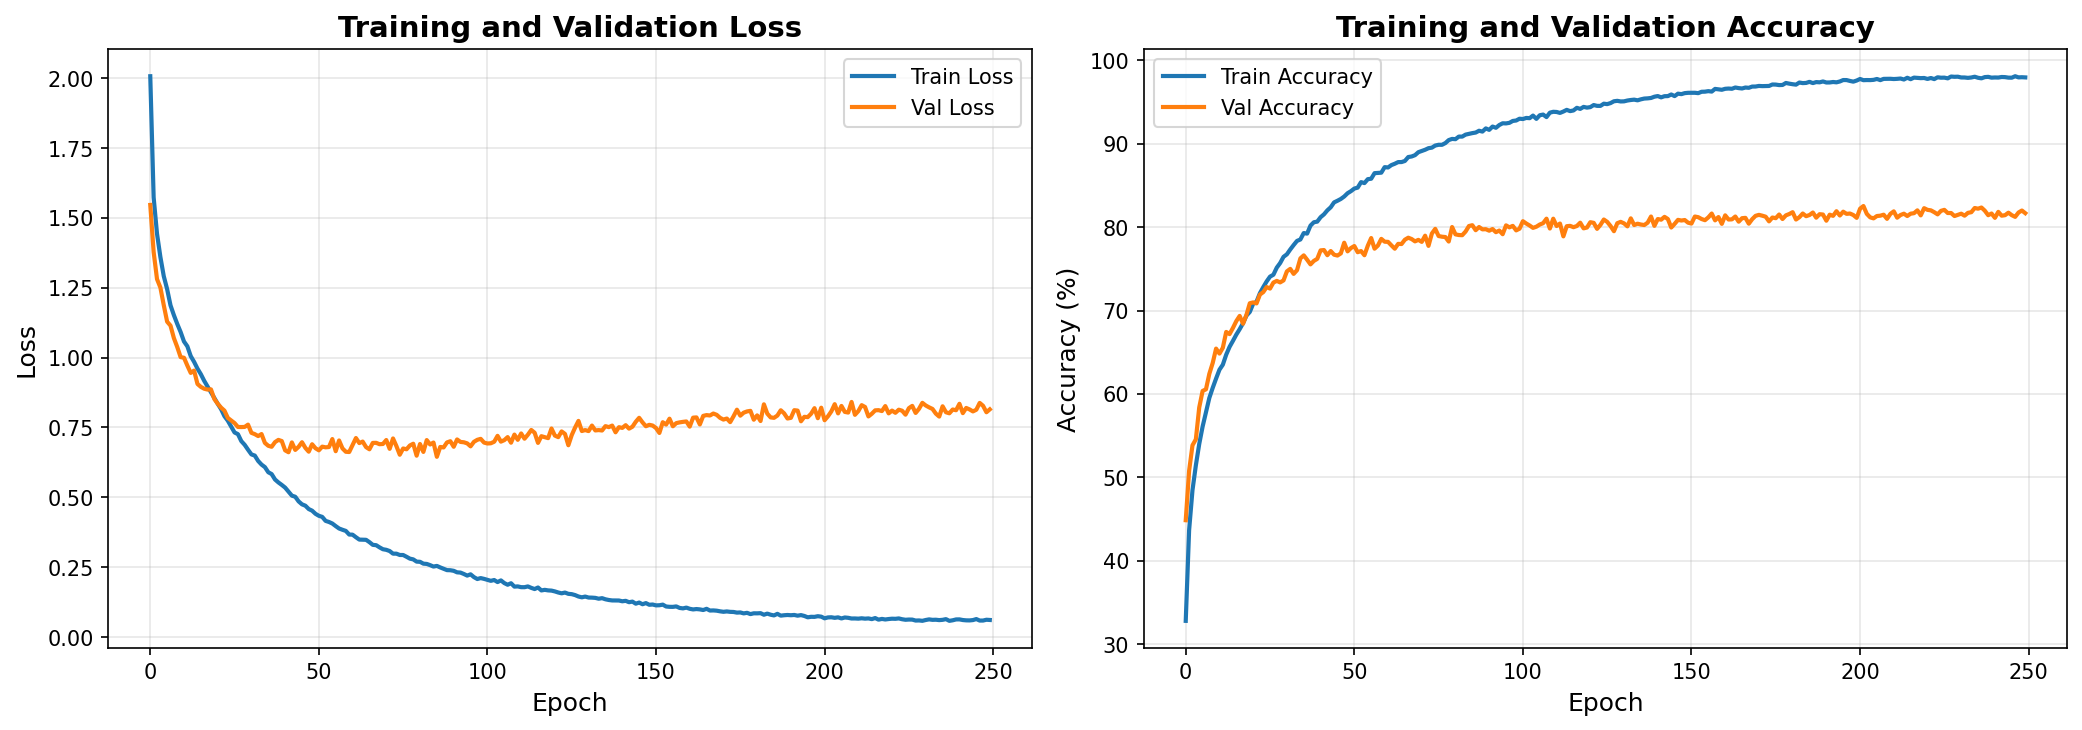

Training curves loaded from saved plot.


In [46]:
# Check if training curves plot exists
curves_path = Path('../results/plots/final_training_curves.png')
if curves_path.exists():
    from IPython.display import Image, display
    display(Image(filename=str(curves_path)))
    print("Training curves loaded from saved plot.")
else:
    print("Training curves not found. Run full training to generate them.")

In [50]:
# Final summary
print("="*60)
print("MODEL PERFORMANCE SUMMARY")
print("="*60)
print(f"\nTest Set Accuracy: {accuracy:.2f}%")
print(f"Number of Classes: {len(class_names)}")
print(f"Model Parameters: {sum(p.numel() for p in model.parameters()):,}")
print(f"Device Used: {device}")
print(f"\nDataset Statistics:")
print(f"  - Training samples: {len(train_loader.dataset)}")
print(f"  - Validation samples: {len(val_loader.dataset)}")
print(f"  - Test samples: {len(test_loader.dataset)}")

# Per-class accuracy
class_correct = np.zeros(len(class_names))
class_total = np.zeros(len(class_names))

for i in range(len(all_labels)):
    label = all_labels[i]
    class_correct[label] += (all_predictions[i] == label)
    class_total[label] += 1

print(f"\nPer-Class Accuracy:")
for i, class_name in enumerate(class_names):
    if class_total[i] > 0:
        acc = 100 * class_correct[i] / class_total[i]
        print(f"  - {class_name}: {acc:.2f}% ({int(class_correct[i])}/{int(class_total[i])})")

# Confidence analysis - FIXED VERSION
print(f"\nConfidence Analysis:")

# Convert tensors to numpy arrays if they are tensors
if len(correct_confidences) > 0 and torch.is_tensor(correct_confidences[0]):
    correct_confidences_np = [conf.item() for conf in correct_confidences]
    incorrect_confidences_np = [conf.item() for conf in incorrect_confidences]
else:
    correct_confidences_np = correct_confidences
    incorrect_confidences_np = incorrect_confidences

# Calculate statistics safely
all_confidences = correct_confidences_np + incorrect_confidences_np

if len(all_confidences) > 0:
    print(f"  - Overall mean confidence: {np.mean(all_confidences):.3f}")
else:
    print(f"  - Overall mean confidence: N/A")

if len(correct_confidences_np) > 0:
    print(f"  - Correct predictions mean confidence: {np.mean(correct_confidences_np):.3f}")
    print(f"  - Correct predictions count: {len(correct_confidences_np)}")
else:
    print(f"  - Correct predictions mean confidence: N/A")

if len(incorrect_confidences_np) > 0:
    print(f"  - Incorrect predictions mean confidence: {np.mean(incorrect_confidences_np):.3f}")
    print(f"  - Incorrect predictions count: {len(incorrect_confidences_np)}")
else:
    print(f"  - Incorrect predictions mean confidence: N/A")

if len(correct_confidences_np) > 0 and len(incorrect_confidences_np) > 0:
    confidence_gap = np.mean(correct_confidences_np) - np.mean(incorrect_confidences_np)
    print(f"  - Confidence gap: {confidence_gap:.3f}")
else:
    print(f"  - Confidence gap: N/A")

# Model architecture info - ROBUST VERSION
print(f"\nModel Architecture:")
print(f"  - Model type: Vision Transformer")

# Safe config access with fallbacks
try:
    image_size = config['data']['image_size']
except KeyError:
    try:
        image_size = config['image_size']
    except KeyError:
        image_size = "Unknown"

try:
    patch_size = config['model']['patch_size']
except KeyError:
    try:
        patch_size = config['patch_size']
    except KeyError:
        patch_size = "Unknown"

try:
    embed_dim = config['model']['embed_dim']
except KeyError:
    try:
        embed_dim = config['embed_dim']
    except KeyError:
        embed_dim = "Unknown"

try:
    depth = config['model']['depth']
except KeyError:
    try:
        depth = config['depth']
    except KeyError:
        depth = "Unknown"

try:
    num_heads = config['model']['num_heads']
except KeyError:
    try:
        num_heads = config['num_heads']
    except KeyError:
        num_heads = "Unknown"

print(f"  - Image size: {image_size}")
print(f"  - Patch size: {patch_size}")
print(f"  - Embedding dimension: {embed_dim}")
print(f"  - Number of layers: {depth}")
print(f"  - Number of heads: {num_heads}")

# Additional performance metrics
print(f"\nPerformance Insights:")
if len(class_names) > 0:
    best_class_idx = np.argmax(class_correct/class_total)
    worst_class_idx = np.argmin(class_correct/class_total)
    print(f"  - Best performing class: {class_names[best_class_idx]} ({np.max(class_correct/class_total)*100:.1f}%)")
    print(f"  - Worst performing class: {class_names[worst_class_idx]} ({np.min(class_correct/class_total)*100:.1f}%)")
    print(f"  - Class performance range: {np.max(class_correct/class_total)*100 - np.min(class_correct/class_total)*100:.1f}%")

# Training information if available
print(f"\nTraining Information:")
try:
    if 'training' in config:
        print(f"  - Learning rate: {config['training'].get('learning_rate', 'Unknown')}")
        print(f"  - Batch size: {config['training'].get('batch_size', 'Unknown')}")
        print(f"  - Epochs: {config['training'].get('epochs', 'Unknown')}")
except:
    print(f"  - Training config not available")

print("\n" + "= "*30)
print("Visualization complete! Check the '../results/plots/' directory for all generated plots.")
print("= "*30)

MODEL PERFORMANCE SUMMARY

Test Set Accuracy: 81.99%
Number of Classes: 10
Model Parameters: 21,268,938
Device Used: cuda

Dataset Statistics:
  - Training samples: 45000
  - Validation samples: 5000
  - Test samples: 10000

Per-Class Accuracy:
  - airplane: 86.00% (860/1000)
  - automobile: 89.70% (897/1000)
  - bird: 72.20% (722/1000)
  - cat: 63.90% (639/1000)
  - deer: 80.30% (803/1000)
  - dog: 74.50% (745/1000)
  - frog: 88.90% (889/1000)
  - horse: 85.80% (858/1000)
  - ship: 88.20% (882/1000)
  - truck: 90.40% (904/1000)

Confidence Analysis:
  - Overall mean confidence: 0.939
  - Correct predictions mean confidence: 0.966
  - Correct predictions count: 8199
  - Incorrect predictions mean confidence: 0.813
  - Incorrect predictions count: 1801
  - Confidence gap: 0.153

Model Architecture:
  - Model type: Vision Transformer
  - Image size: 72
  - Patch size: 6
  - Embedding dimension: Unknown
  - Number of layers: Unknown
  - Number of heads: 4

Performance Insights:
  - Best p